In [152]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
data = pd.read_csv('./data.csv')
target = 'status'

data[target] = data[target].replace({'legitimate': 0, 'phishing': 1})

urls = data['url']
X = data.drop(columns=['url', target])
y = data[target]

urls_train, urls_test, X_train, X_test, y_train, y_test = train_test_split(urls, X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)

In [3]:
data

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,0
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,1
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,1
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,0
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,http://www.fontspace.com/category/blackletter,45,17,0,2,0,0,0,0,0,...,0,0,0,448,5396,3980,0,0,6,0
11426,http://www.budgetbots.com/server.php/Server%20...,84,18,0,5,0,1,1,0,0,...,1,0,0,211,6728,0,0,1,0,1
11427,https://www.facebook.com/Interactive-Televisio...,105,16,1,2,6,0,1,0,0,...,0,0,0,2809,8515,8,0,1,10,0
11428,http://www.mypublicdomainpictures.com/,38,30,0,2,0,0,0,0,0,...,1,0,0,85,2836,2455493,0,0,4,0


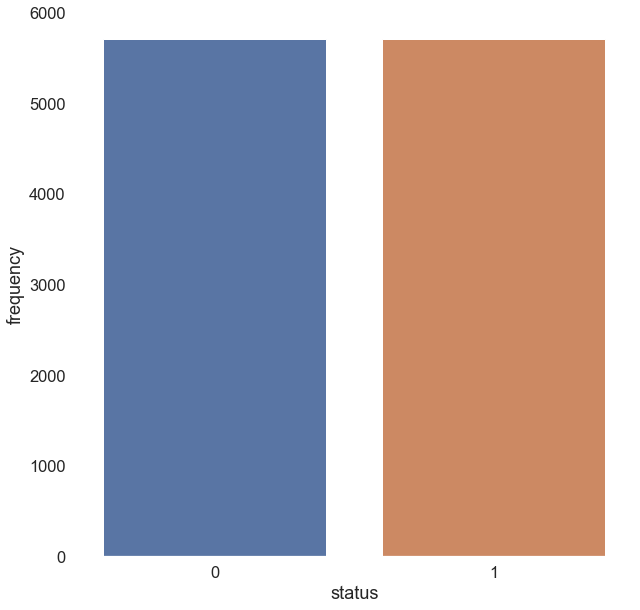

In [180]:
sns.set(font_scale=1.5)

target_freq = y.value_counts().to_frame().reset_index().rename({'status': 'frequency', 'index': 'status'}, axis=1)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_facecolor('white')
sns.barplot(data=target_freq, x=target, y='frequency')

plt.savefig('target_distribution.svg')

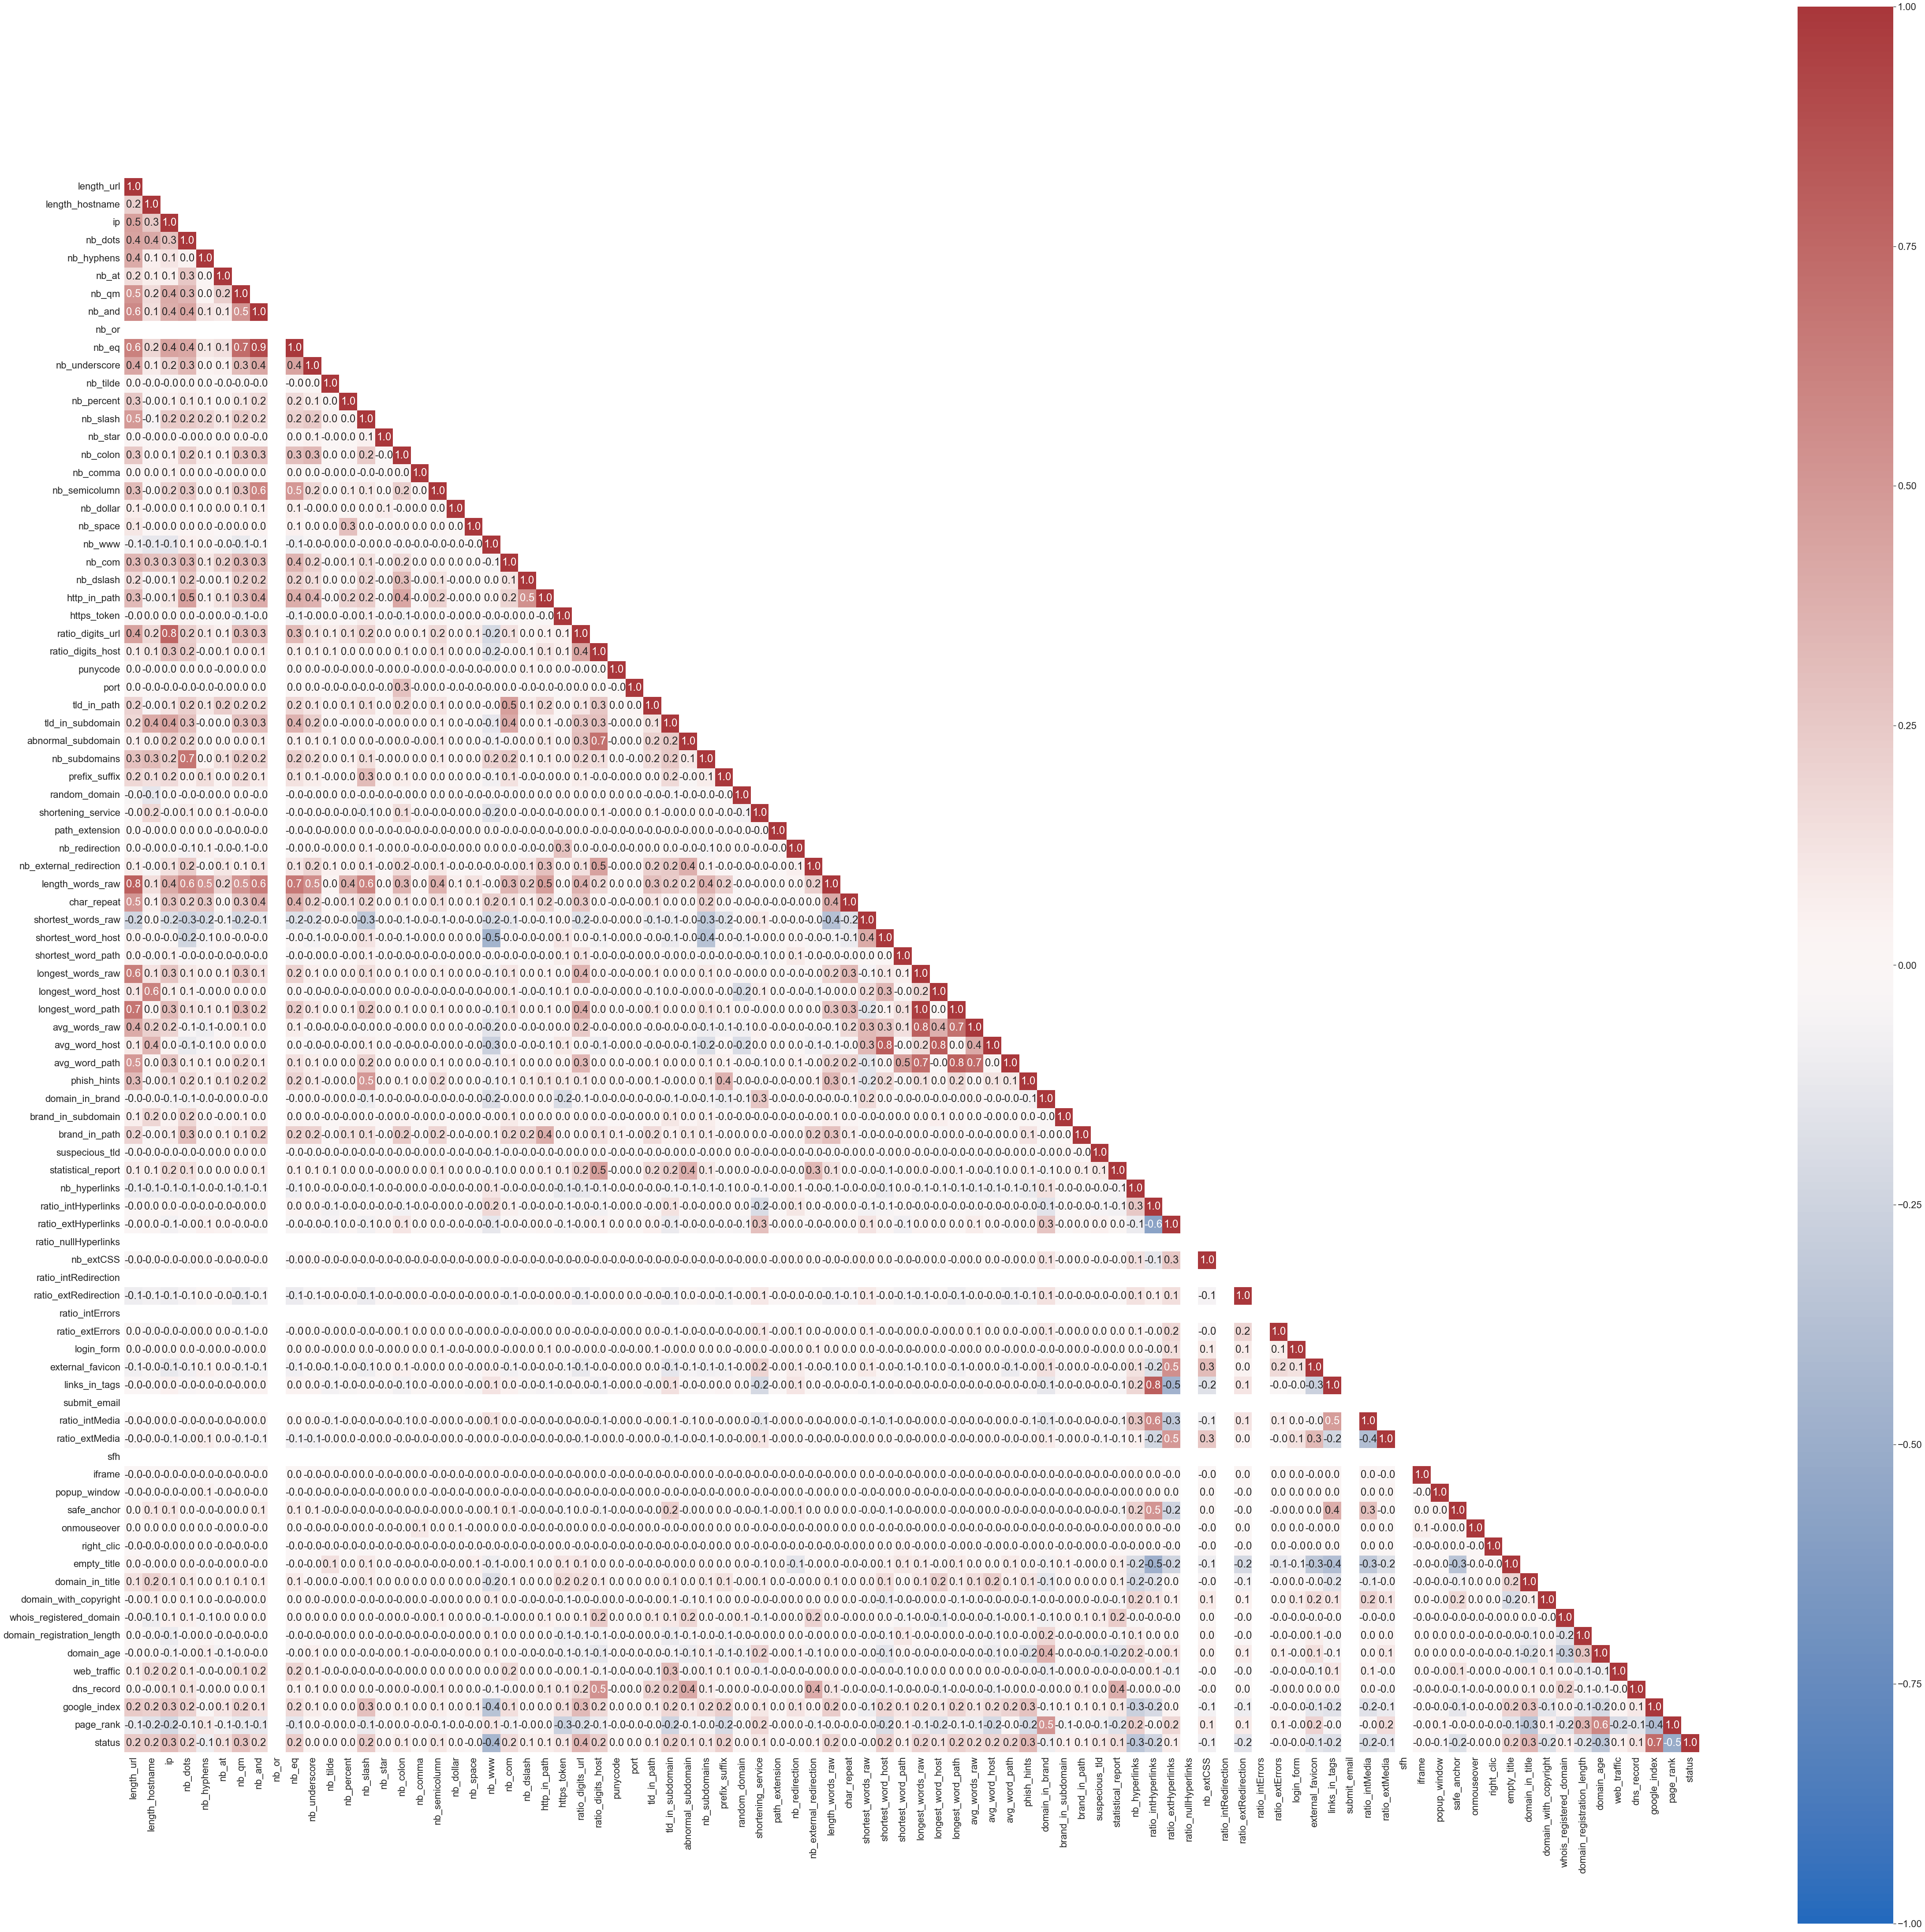

In [181]:
sns.set(font_scale=2)

corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

fig, ax = plt.subplots(figsize=(80,80))
ax.set_facecolor('white')
sns.heatmap(corr, mask=mask, annot=True, square=True, cmap='vlag', vmin=-1, vmax=1, fmt='.1f', ax=ax)

plt.savefig('corr_heatmap.svg')

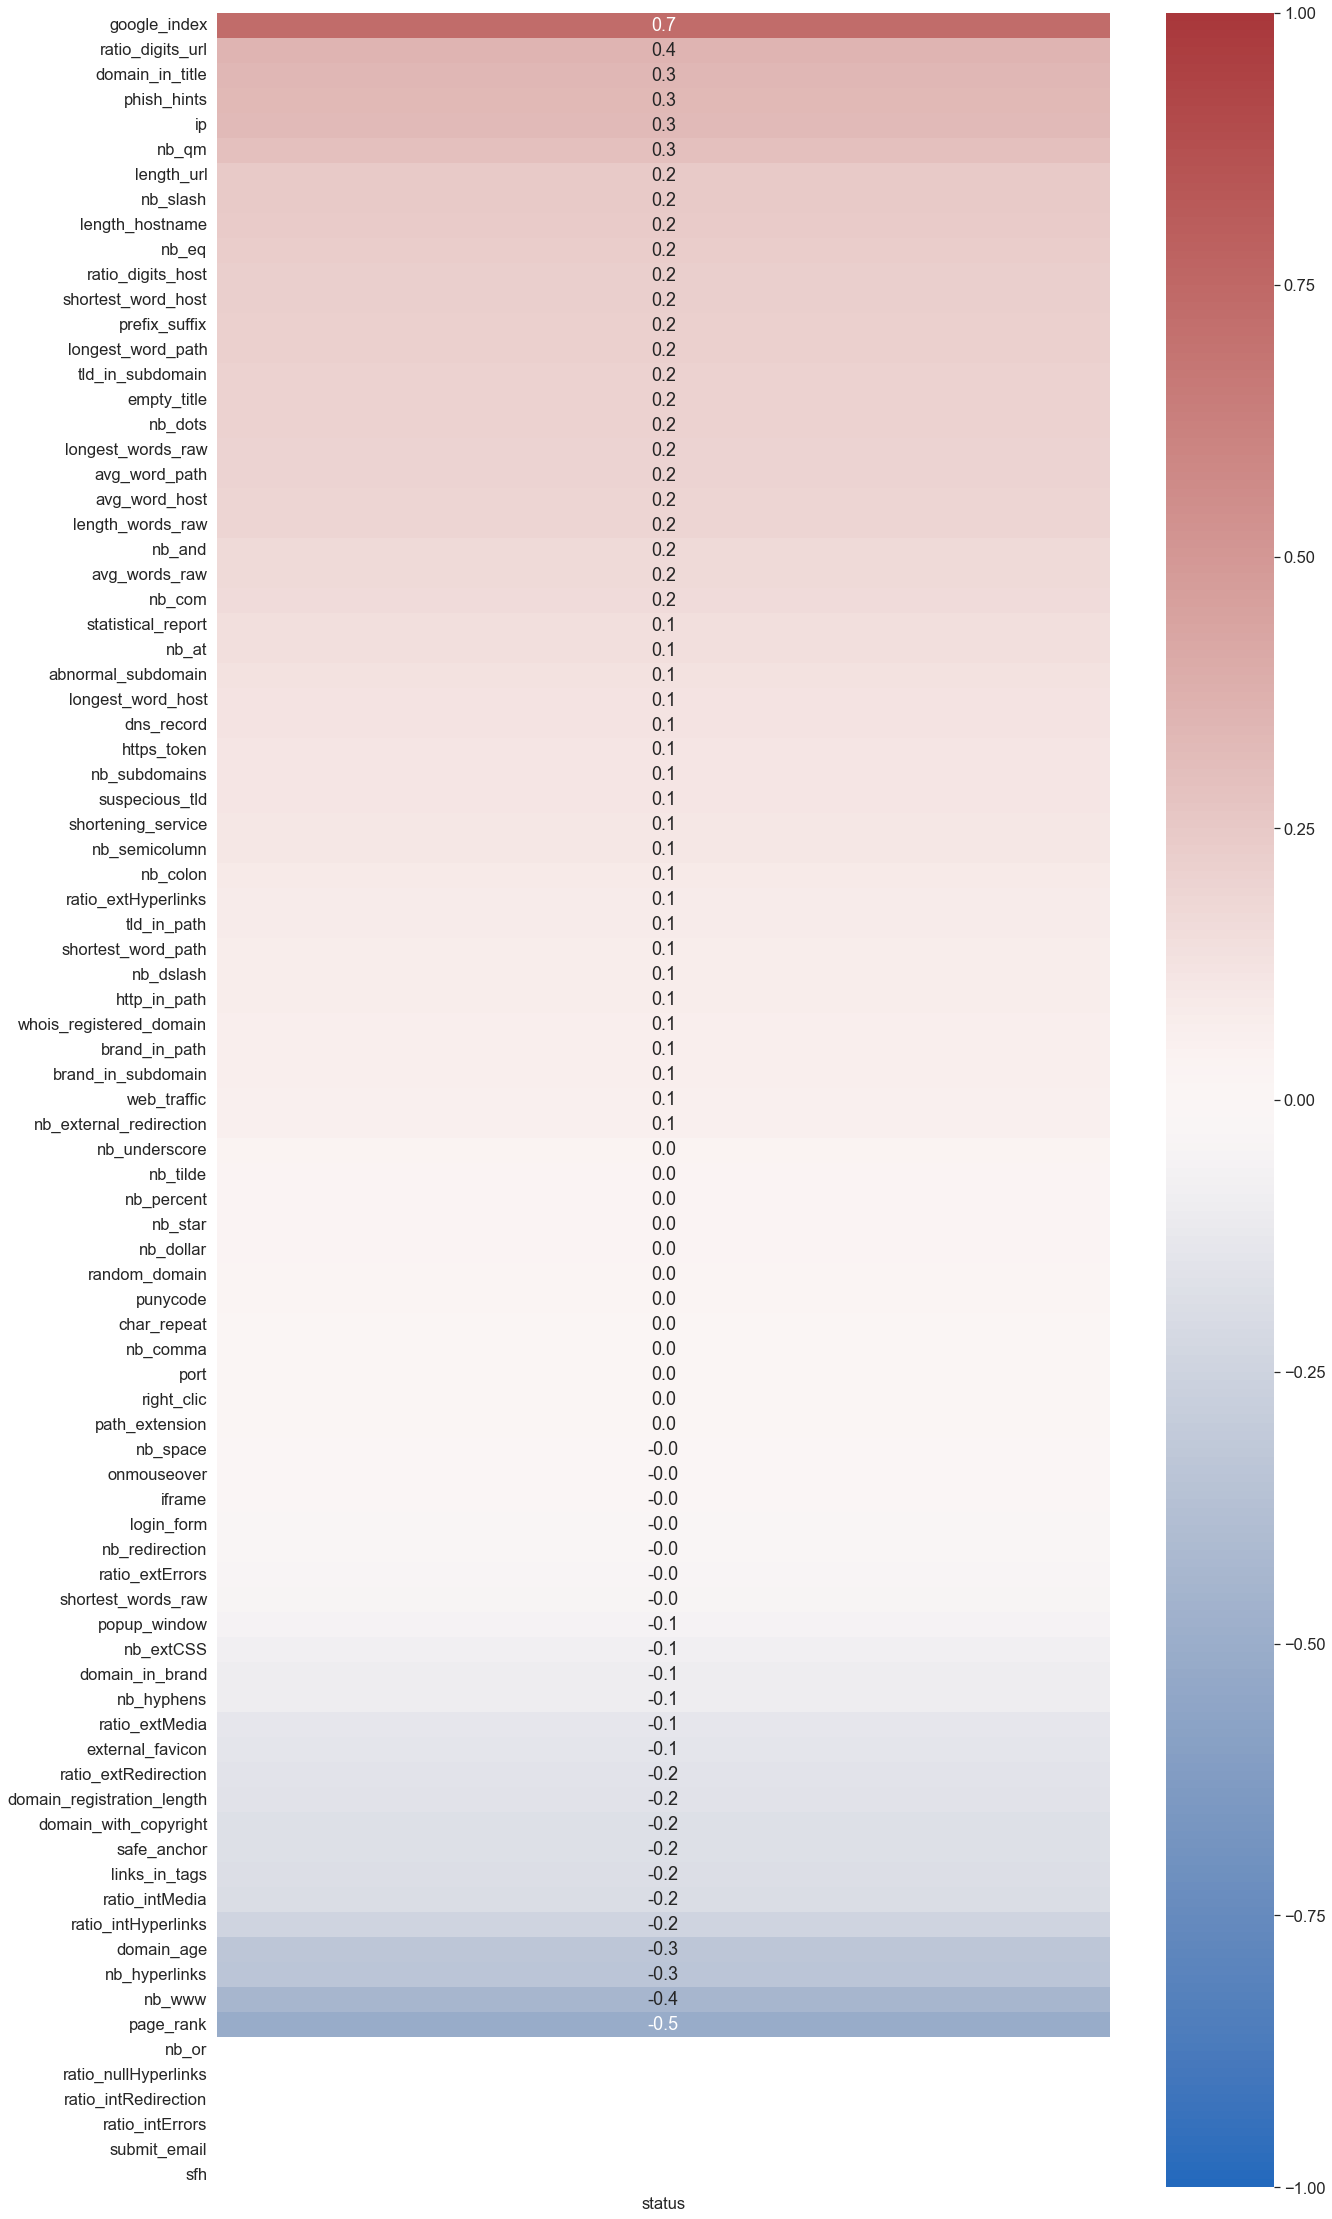

In [182]:
sns.set(font_scale=1.5)

corr_target = data.corr()[[target]]
corr_target = corr_target.loc[corr_target.index != target]

fig, ax = plt.subplots(figsize=(20,40))
ax.set_facecolor('white')
sns.heatmap(corr_target.sort_values(by=[target], ascending=False), annot=True, cmap='vlag', vmin=-1, vmax=1, fmt='.1f', ax=ax)

plt.savefig('target_corr_heatmap.svg')

In [151]:
feats_schar_counts = ['nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space']
feats_cterms_counts = ['nb_www', 'nb_com', 'nb_dslash']

schar_summer = FunctionTransformer(lambda X: X.sum(axis=1).to_frame(), feature_names_out=lambda *args: ['total_schars'])
cterm_summer = FunctionTransformer(lambda X: X.sum(axis=1).to_frame(), feature_names_out=lambda *args: ['total_cterms'])
traffic_age_divider = FunctionTransformer(lambda X: (X['web_traffic'] / X['domain_age'].replace(-1, np.nan)).fillna(-1).to_frame(), feature_names_out=lambda *args: ['traffic_age_ratio'])
tschar_ulength_divider = FunctionTransformer(lambda X: (X.loc[:, X.columns != 'length_url'].sum(axis=1) / X['length_url']).to_frame(), feature_names_out=lambda *args: ['tshcar_ulength_ratio'])

feat_extractor = ColumnTransformer([
    ('passthrough', 'passthrough', X.columns),
    ('schar_summer', schar_summer, feats_schar_counts),
    ('cterm_summer', cterm_summer, feats_cterms_counts),
    ('traffic_age_divider', traffic_age_divider, ['web_traffic', 'domain_age']),
    ('tschar_ulength_divider', tschar_ulength_divider, [*feats_schar_counts, 'length_url'])
], verbose_feature_names_out=False)

sclf = StackingClassifier(
    estimators=[
        # ('lr', LogisticRegression(max_iter=1000)),
        ('rfc', RandomForestClassifier(criterion='entropy')),
        ('etc', ExtraTreesClassifier(criterion='entropy')),
        # ('abc', AdaBoostClassifier()),
        ('cbc', CatBoostClassifier(verbose=0)),
        ('xgbc', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ],
    # final_estimator=GeneralizedMeanBlender(p_range=(-20, 20)),
    final_estimator=MLPClassifier(hidden_layer_sizes=(8, 4), alpha=0.2, max_iter=1000, early_stopping=True, n_iter_no_change=50, verbose=True, random_state=42),
)

pipe = Pipeline(steps=[
    ('feat_extraction', feat_extractor), 
    ('scaling', StandardScaler()),
    ('classification', sclf)
])
pipe

Pipeline(steps=[('feat_extraction',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  Index(['length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at',
       'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore', 'nb_tilde',
       'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma',
       'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com',
       'nb_dsl...
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None,
                                                               reg_alpha=None,
                                                               reg_lambda=None,
                                                               scale_pos_weight=None,
                                                               subsample=None,
                                                               tree_method=None,
                                                               use_label_encoder=False,
                                                               validate_parameters=None,
                                                               verbosity=None))],
                                    final_estimator=MLPClassifier(alpha=0.2,
                                                                  early_stopping=True,
                                                                  hidden_layer_sizes=(8,
                                                                                      4),
                                                                  max_iter=1000,
                                                                  n_iter_no_change=50,
                                                                  random_state=42,
                                                                  verbose=True)))])

In [155]:
cv_results = cross_validate(pipe, X, y, return_train_score=True, verbose=True, n_jobs=-1, scoring=[
    'accuracy', 
    'precision', 'precision_macro',
    'recall', 'recall_macro', 
    'f1', 'f1_macro',
    'roc_auc',
    'neg_log_loss',
])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.8min finished


In [156]:
cv_results

{'fit_time': array([399.05548096, 401.00048995, 402.21005964, 399.1794858 ,
        170.95811915]),
 'score_time': array([0.55100107, 0.97299767, 0.50799918, 0.7220006 , 0.41200161]),
 'test_accuracy': array([0.97112861, 0.96937883, 0.97594051, 0.96587927, 0.97287839]),
 'train_accuracy': array([0.99989064, 1.        , 1.        , 1.        , 1.        ]),
 'test_precision': array([0.98037467, 0.96692776, 0.98056537, 0.96587927, 0.97705207]),
 'train_precision': array([1., 1., 1., 1., 1.]),
 'test_precision_macro': array([0.97130321, 0.96939176, 0.97598459, 0.96587927, 0.97291459]),
 'train_precision_macro': array([0.99989066, 1.        , 1.        , 1.        , 1.        ]),
 'test_recall': array([0.96150481, 0.9720035 , 0.97112861, 0.96587927, 0.96850394]),
 'train_recall': array([0.99978128, 1.        , 1.        , 1.        , 1.        ]),
 'test_recall_macro': array([0.97112861, 0.96937883, 0.97594051, 0.96587927, 0.97287839]),
 'train_recall_macro': array([0.99989064, 1.        ,

In [161]:
import json

with open('./cv_results.json', 'w') as f:
    json.dump({key: list(val) for key, val in cv_results.items()}, f, indent=4)

In [167]:
cv_results_test = {key: val for key, val in cv_results.items() if key.startswith('test')}
cv_results_train = {key: val for key, val in cv_results.items() if key.startswith('train')}
cv_results_test

{'test_accuracy': array([0.97112861, 0.96937883, 0.97594051, 0.96587927, 0.97287839]),
 'test_precision': array([0.98037467, 0.96692776, 0.98056537, 0.96587927, 0.97705207]),
 'test_precision_macro': array([0.97130321, 0.96939176, 0.97598459, 0.96587927, 0.97291459]),
 'test_recall': array([0.96150481, 0.9720035 , 0.97112861, 0.96587927, 0.96850394]),
 'test_recall_macro': array([0.97112861, 0.96937883, 0.97594051, 0.96587927, 0.97287839]),
 'test_f1': array([0.97084806, 0.96945899, 0.97582418, 0.96587927, 0.97275923]),
 'test_f1_macro': array([0.97112593, 0.96937862, 0.97593995, 0.96587927, 0.97287787]),
 'test_roc_auc': array([0.99044739, 0.99254697, 0.99054613, 0.99142217, 0.9937686 ]),
 'test_neg_log_loss': array([-0.26875005, -0.17256436, -0.35701785, -0.20272001, -0.20462365])}

In [169]:
cv_results_test_mean = {key: val.mean() for key, val in cv_results_test.items()}
cv_results_test_mean

{'test_accuracy': 0.9710411198600175,
 'test_precision': 0.9741598278011431,
 'test_precision_macro': 0.9710946840562175,
 'test_recall': 0.9678040244969379,
 'test_recall_macro': 0.9710411198600175,
 'test_f1': 0.970953942390054,
 'test_f1_macro': 0.971040327601908,
 'test_roc_auc': 0.9917462526283078,
 'test_neg_log_loss': -0.24113518312856175}

In [179]:
cv_results_test_df = pd.DataFrame.from_dict(cv_results_test, orient='index')
cv_results_test_df['mean'] = cv_results_test_df.mean(axis=1)
cv_results_test_df = cv_results_test_df.round(3)
cv_results_test_df

,0,1,2,3,4,mean
test_accuracy,0.971,0.969,0.976,0.966,0.973,0.971
test_precision,0.980,0.967,0.981,0.966,0.977,0.974
test_precision_macro,0.971,0.969,0.976,0.966,0.973,0.971
test_recall,0.962,0.972,0.971,0.966,0.969,0.968
test_recall_macro,0.971,0.969,0.976,0.966,0.973,0.971
test_f1,0.971,0.969,0.976,0.966,0.973,0.971
test_f1_macro,0.971,0.969,0.976,0.966,0.973,0.971
test_roc_auc,0.990,0.993,0.991,0.991,0.994,0.992
test_neg_log_loss,-0.269,-0.173,-0.357,-0.203,-0.205,-0.241
